In [1]:
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

import os
import PIL
import PIL.Image as Image

seed_choice = 42
tf.keras.utils.set_random_seed(
    seed_choice
)

2.12.0


In [2]:
#!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [3]:
from  IPython import display


import pathlib
import shutil
import tempfile


In [4]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [5]:
from google.colab import drive
drive.mount('gdrive')

Drive already mounted at gdrive; to attempt to forcibly remount, call drive.mount("gdrive", force_remount=True).


In [6]:
archive = 'gdrive/MyDrive/Datasets/plants'
data_dir = pathlib.Path(archive).with_suffix('')

In [7]:
data_dir

PosixPath('gdrive/MyDrive/Datasets/plants')

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


288


In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.35,
  subset="training",
  seed=seed_choice,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 288 files belonging to 2 classes.
Using 188 files for training.


In [11]:
STEPS_PER_EPOCH = len(train_ds)

In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.35,
  subset="validation",
  seed=seed_choice,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 288 files belonging to 2 classes.
Using 100 files for validation.


In [13]:
validate_ds =  val_ds

In [14]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'wilted']


In [15]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

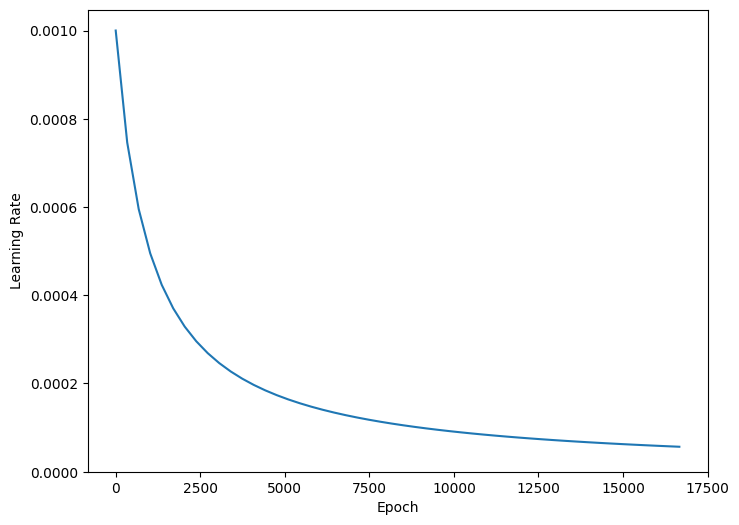

In [16]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')


In [17]:
def get_callbacks(name):
  return [
    tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [18]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=[
                  tf.keras.metrics.BinaryCrossentropy(
                      from_logits=True, name='binary_crossentropy'),
                  'accuracy'])

  model.summary()

  history = model.fit(
    train_ds,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=validate_ds,
    callbacks=get_callbacks(name),
    verbose=1)
  return history

In [19]:
INPUT_SHAPE = (None, 180, 180, 3)

In [20]:

tiny_model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1)])

tiny_model.build(INPUT_SHAPE)

In [21]:
size_histories = {}

In [22]:
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 flatten (Flatten)           (None, 1013888)           0         
                                                                 
 dense (Dense)               (None, 1)                 1013889   
                                                                 
Total params: 1,014,785
Trainable params: 1,014,785
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==============================] - 13s 293ms/step - loss: 2.9144 - binary_crossentropy: 2.9144 - accuracy: 0.5426 - val_loss: 2.2710 - val_binary_crossentropy: 2.2

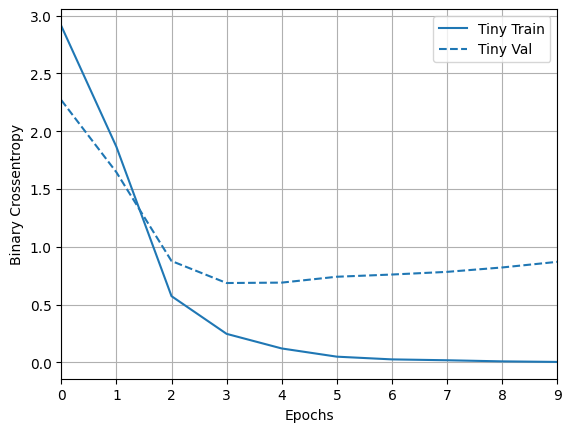

In [23]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
#plt.ylim([0.5, 0.7])


In [24]:
num_classes = 1

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [25]:
model.build(INPUT_SHAPE)

In [26]:
size_histories['ConvPool'] = compile_and_fit(model, 'sizes/ConvPool')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 41, 41, 32)       

(0.0, 1.0)

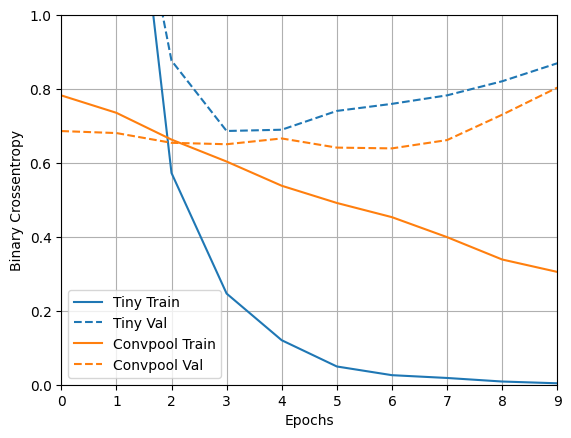

In [27]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.0, 1.0])


In [28]:
model2 = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

model2.build(INPUT_SHAPE)

In [29]:
size_histories['Dropout'] = compile_and_fit(model2, 'sizes/Dropout')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 flatten_2 (Flatten)         (None, 97200)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               12441728  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 12,441,857
Trainable params: 12,441,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
6/6 [==========================

(0.0, 1.0)

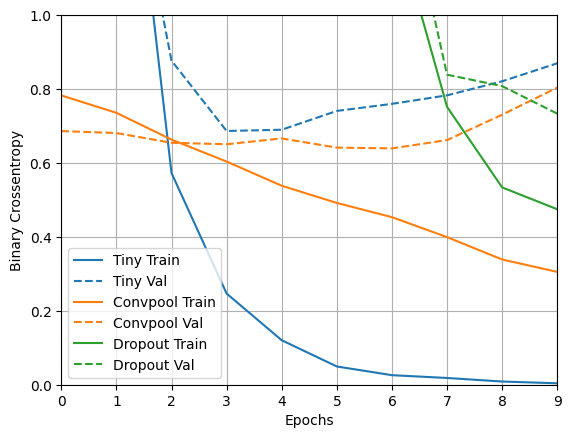

In [30]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.0, 1.0])


In [31]:
model3 = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

model3.build(INPUT_SHAPE)

size_histories['ConvPoolDropout'] = compile_and_fit(model3, 'sizes/ConvPoolDropout')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 87, 87, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 41, 41, 32)       

(0.0, 1.0)

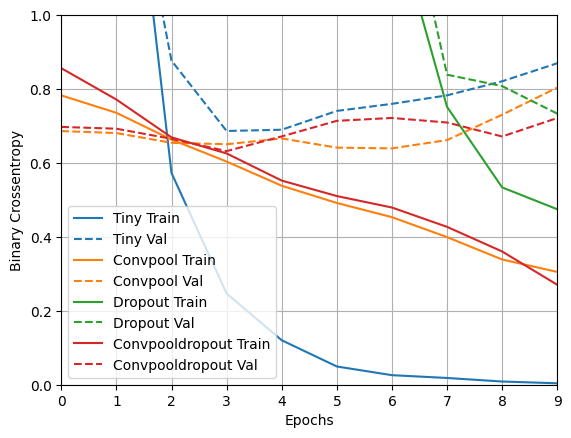

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.0, 1.0])
